In [3]:
# This is a script to generate low-precision low-rank approximations for matrices
import sys
sys.path.append('/home/ubuntu/disk1/Fyq-workspace/Projects/codes/matrix-compressor/src')

import pathlib
from datetime import datetime
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import torch
from phantominator import shepp_logan

from lplr.compressors import direct_svd_quant, lplr, lplr_svd
from lplr.quantizers import quantize
from lplr.utils import maximum_output_rank

# plt.rcParams["figure.figsize"] = [20, 18]
plt.rcParams.update({"font.size": 10})

SEED = int(datetime.now().timestamp())

In [4]:
def save_image(mat, bp, name):
    plt.clf()
    plt.set_cmap("gray")
    im = plt.imshow(mat)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(bp / name, bbox_inches="tight", pad_inches=0)


def relative_error(X, Y):
    return (
        torch.linalg.norm(X - Y, ord="fro") / torch.linalg.norm(Y, ord="fro")
    ).item()


def paper_output():
    # Load phantom image
    P = shepp_logan(1000)
    P = torch.from_numpy(np.interp(P, (P.min(), P.max()), (0, 1)))

    base_output_path = pathlib.Path(f"artifacts/paper")
    base_output_path.mkdir(parents=True, exist_ok=True)

    print(f"Shepp logan output rank = {np.linalg.matrix_rank(P)}")
    b1_range = [8]
    b2_range = [4]
    b_nq_range = [1, 2]

    save_image(P, base_output_path, "original.png")
    records = []
    for b1, b2, b_nq in product(b1_range, b2_range, b_nq_range):
        rr = maximum_output_rank(1, b1, b2, b_nq, P.shape)

        output_dir = base_output_path / f"rank-{rr}_b1-{b1}_b2-{b2}_b0-{b_nq}"
        output_dir.mkdir(parents=True, exist_ok=True)

        log_file = output_dir / "eval.log"

        print(f"processing b1 = {b1} b_nq = {b_nq} rank = {rr}")

        with open(log_file, "w") as f:
            P_direct = direct_svd_quant(X=P, r=rr, B1=b1, B2=b2, normalize_and_shift=True)
            err_direct_svd = relative_error(P_direct, P)
            print(f"Error (Direct SVD): {err_direct_svd}", file=f)
            save_image(P_direct, output_dir, "dsvd.png")

            P_lplr = lplr(X=P, r=rr, B1=b1, B2=b2, normalize_and_shift=True)
            err_lplr = relative_error(P_lplr, P)
            print(f"Error (LPLR): {err_lplr}", file=f)
            save_image(P_lplr, output_dir, "lplr.png")

            P_lsvd = lplr_svd(X=P, r=rr, B1=b1, B2=b2, normalize_and_shift=True)
            err_lsvd = relative_error(P_lsvd, P)
            print(f"Error (LSVD): {err_lsvd}", file=f)
            save_image(P_lsvd, output_dir, "lsvd.png")

            P_nq = quantize(P, b_nq)
            err_nq = relative_error(P_nq, P)
            print(f"Error (NQ): {err_nq}", file=f)
            save_image(P_nq, output_dir, "nq.png")

            records.append(
                {
                    "B1": b1,
                    "B2": b2,
                    "Rank": rr,
                    "Bnq": b_nq,
                    "NQ": err_nq,
                    "DSVD": err_direct_svd,
                    "LPLR": err_lplr,
                    "LSVD": err_lsvd
                }
            )

    import pandas as pd

    df = pd.DataFrame.from_records(records)
    print(df.sort_values(["Bnq", "Rank"]).to_string(index=False))

Shepp logan output rank = 539
processing b1 = 8 b_nq = 1 rank = 83


2024-05-18 22:29:06.449 | WARNING  | lplr.quantizers:quantize:44 - Using simulation to quantize to 8 bits
2024-05-18 22:29:06.522 | WARNING  | lplr.quantizers:quantize:44 - Using simulation to quantize to 4 bits
2024-05-18 22:29:06.625 | WARNING  | lplr.quantizers:quantize:44 - Using simulation to quantize to 8 bits
2024-05-18 22:29:06.632 | WARNING  | lplr.quantizers:quantize:44 - Using simulation to quantize to 4 bits


Elapsed time: 0.0723 seconds
Elapsed time: 0.0036 seconds
Elapsed time: 0.3387 seconds
Elapsed time: 0.0039 seconds
Elapsed time: 0.0035 seconds
Elapsed time: 0.0136 seconds


2024-05-18 22:29:06.730 | WARNING  | lplr.quantizers:quantize:44 - Using simulation to quantize to 1 bits


Elapsed time: 0.0121 seconds
processing b1 = 8 b_nq = 2 rank = 166


2024-05-18 22:29:07.064 | WARNING  | lplr.quantizers:quantize:44 - Using simulation to quantize to 8 bits
2024-05-18 22:29:07.141 | WARNING  | lplr.quantizers:quantize:44 - Using simulation to quantize to 4 bits
2024-05-18 22:29:07.248 | WARNING  | lplr.quantizers:quantize:44 - Using simulation to quantize to 8 bits
2024-05-18 22:29:07.261 | WARNING  | lplr.quantizers:quantize:44 - Using simulation to quantize to 4 bits


Elapsed time: 0.0776 seconds
Elapsed time: 0.0053 seconds
Elapsed time: 0.3363 seconds
Elapsed time: 0.0057 seconds
Elapsed time: 0.0055 seconds
Elapsed time: 0.0227 seconds


2024-05-18 22:29:07.360 | WARNING  | lplr.quantizers:quantize:44 - Using simulation to quantize to 2 bits
/home/ubuntu/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Elapsed time: 0.0184 seconds
 B1  B2  Rank  Bnq     LPLR     DSVD       NQ
  8   4    83    1 0.343132 0.479759 0.532290
  8   4   166    2 0.316197 0.595284 0.312196


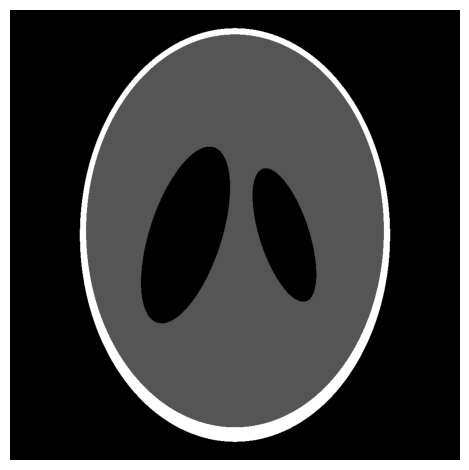

In [5]:
paper_output()